In [1]:
%matplotlib inline

In [2]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import models
import statsmodels.api as sm
import patsy


sns.set(style="whitegrid")

# Problem Set 5 (covers Lab 9 and 10)

## Directions

1. Show all work/steps/calculations using a combination of code and Markdown. You will submit only this notebook named: [jhed_id].ipynb back to Blackboard from whence you downloaded it. Do not return the data to me.
2. **All** work is to be your own. This is not a group project. You may, however, use code from the lectures and labs. Provide citations for any code that is not your own. You may also consult Stackoverflow, etc. This is not by any means "closed book" or anything like that. Basically, I need to see if *you* learned the concepts from the Lectures, *Fundamentals*, and Labs.
3. Add whatever markdown or code cells you need in each part to explain and calculate your answers. Don't just provide answers but explain them as well. **Explain and interpret your results.**

## Introduction

Labs 9 and 10 were all about linear models, specifically linear and logistic regression. We learned how to build and interpret multivariate models by using domain knowledge, comparing the predicted and actual values of the coefficients and the credible intervals, and looking at residuals. We also applied transformations to make the models perform better and increase interpretability.

Using the techniques covered during Modules 9 and 10 (lectures, labs, course notes), **build, describe, and use** a linear regression model that estimates the target variable `mpg` for the accompanying auto data set. You may use other techniques you know but you must at least use the techniques described in class and call out and describe anything "extra" that you do and why.

Do **not** use any feature selection techniques or anything other than linear regression. Follow the method described in class.

The instructions say build, **describe, and use**. You must describe all aspects of your final model (all the parameters and metrics) and use it to predict one value as described in the course notes.

In [3]:
autompg = pd.read_csv("auto-mpg-no-missing.data.csv")

In [4]:
autompg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null int64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
car name        392 non-null object
dtypes: float64(3), int64(5), object(1)
memory usage: 27.6+ KB


In [5]:
autompg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


There are 9 variables however the car name is unique for each row so that will not be included in the regression. Origin can be considered categorical as there are only a three possible values. There is no indication of what they determine though.

What is the expected relationship between each variable and our target variable, MPG

**Cylinders**: I am not too knowledgable about cars but I believe the more cylinders the less MPG, so this will be negative.

**Displacement**: Similarly with displacement, the more displacement the more power the car uses and therefore the lower the MPG. This will be a negative relationship.

**Horsepower**: Again, the more horsepower, the harder the car is working and therefore the lower the mpg. This will be a negative relationship.

**Weight**: The heavier the car the more the engine will have to work and therefore the lower the mpg. This will also be negative.

**Acceleration**: The faster the car can accelerate, the more the engine is working and the lower the mpg. This will also have a negative relationship.

**Model Year**: As car technology progresses I would expect mpg to decrease. Therefore the later the model year, the more mpg the car will have. I expect a positive relationship.

**Origin**: I do not know what the origin variable is. There are three values (1, 2, and 3) which can be treated as cartegorical. I do not know what to expect then. 

## Dummy Variable Creation

In [6]:
origin = pd.get_dummies(autompg["origin"])

In [7]:
origin.head()

,1,2,3
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [8]:
autompg["origin1"] = origin[1]
autompg["origin2"] = origin[2]

I don't need the 3 variable since I have the first two.

I also handled the missing horsepower values by removing them in the excel file.

## Model Building

In [9]:
def adjusted_r_squared(result):
    adjustment = (result["n"] - 1)/(result["n"] - len(result["coefficients"]) - 1 - 1)
    return 1 - (1 - result["r_squared"]) * adjustment

In [10]:
model = "mpg ~ cylinders + displacement + horsepower + weight + acceleration + year + origin1 + origin2"
result = models.bootstrap_linear_regression(model, data=autompg)
display(models.describe_bootstrap_lr(result))

In [11]:
adjusted_r_squared(result)

0.8195852827704978

The R^2 of the model with no changes of .82 is pretty good. The standard deviation of 3.31 is not too large either. But we should look at the coefficients and if they are what I expected.

In [12]:
#from the book
def evaluate_coefficient_predictions(predictions, result):
    coefficients = result["resampled_coefficients"].columns
    for coefficient in coefficients:
        if coefficient == 'intercept':
            continue
        if predictions[coefficient] == '+':
            print("{0} P(>0)={1:.3f}".format(coefficient, np.mean(result["resampled_coefficients"][coefficient] > 0)))
        else:
            print("{0} P(<0)={1:.3f}".format(coefficient, np.mean(result["resampled_coefficients"][coefficient] < 0)))

In [13]:
predictions = {"cylinders": "-", "displacement": "-", "horsepower": "-", "weight": "-", "acceleration": "-", "year": "+", "origin1": "+", "origin2": "+"}
evaluate_coefficient_predictions(predictions, result)

cylinders P(<0)=0.940
displacement P(<0)=0.000
horsepower P(<0)=0.940
weight P(<0)=1.000
acceleration P(<0)=0.190
year P(>0)=1.000
origin1 P(>0)=0.000
origin2 P(>0)=0.330


Cylinders has a high probability of having a negative coefficient whihc is what we expected. Displacement however has no chance of being negative. Horsepower has a high chance of being negative and weight is guaranteed to be negative. Acceleration is positive with a low chance of being negative. Year is 100% positive and both origins are more likely negative but I didn't know what to expect from them.

With that info we can probably remove displacement and accerleration from the model. There also may be some correlation between the variables. 

In [14]:
print("displacement v cylinders = {0:.2f}".format(stats.pearsonr(autompg.displacement, autompg.cylinders)[0]))

displacement v cylinders = 0.95


In [15]:
print("horsepower v cylinders = {0:.2f}".format(stats.pearsonr(autompg.horsepower, autompg.cylinders)[0]))

horsepower v cylinders = 0.84


In [16]:
print("acceleration v cylinders = {0:.2f}".format(stats.pearsonr(autompg.acceleration, autompg.cylinders)[0]))

acceleration v cylinders = -0.50


In [17]:
print("acceleration v weight = {0:.2f}".format(stats.pearsonr(autompg.acceleration, autompg.weight)[0]))

acceleration v weight = -0.42


Both horsepower and displacement are highly correlated to cylinders. We can keep cylinders then and remove the other two to see how the model performs and affects the acceleration coefficient.

In [18]:
model = "mpg ~ cylinders + weight + acceleration + year + origin1 + origin2"
result = models.bootstrap_linear_regression(model, data=autompg)
display(models.describe_bootstrap_lr(result))

In [19]:
adjusted_r_squared(result)

0.8158432335113667

In [20]:
predictions = {"cylinders": "-", "weight": "-", "acceleration": "-", "year": "+", "origin1": "+", "origin2": "+"}
evaluate_coefficient_predictions(predictions, result)

cylinders P(<0)=0.300
weight P(<0)=1.000
acceleration P(<0)=0.220
year P(>0)=1.000
origin1 P(>0)=0.000
origin2 P(>0)=0.290


The R^2 is the same but the coefficients changed quite a bit. Cylinders may not be the best one to keep around as there are few possible values for it. I would like to try removing cylinders and keeping the others. But also I want to check the correlation between horsepower and displacement.

In [21]:
print("displacement v horsepower = {0:.2f}".format(stats.pearsonr(autompg.displacement, autompg.horsepower)[0]))

displacement v horsepower = 0.90


That is also high so there should still only be one of these three in the model. I will keep horsepower.

In [22]:
model = "mpg ~ horsepower + weight + acceleration + year + origin1 + origin2"
result = models.bootstrap_linear_regression(model, data=autompg)
display(models.describe_bootstrap_lr(result))

In [23]:
predictions = {"horsepower": "-", "weight": "-", "acceleration": "-", "year": "+", "origin1": "+", "origin2": "+"}
evaluate_coefficient_predictions(predictions, result)

horsepower P(<0)=0.660
weight P(<0)=1.000
acceleration P(<0)=0.400
year P(>0)=1.000
origin1 P(>0)=0.000
origin2 P(>0)=0.390


This time it's a bit better. Horsepower has a higher probability of being negative at .7 and acceleration still has a probability of being negative as well.

R^2 still is at .82 though so the model did not change much there.

Let's review the adjusted R^2 as well.

In [24]:
adjusted_r_squared(result)

0.8157252808940341

The adjusted R^2 did not change much at all either. Let's look at the residuals then.

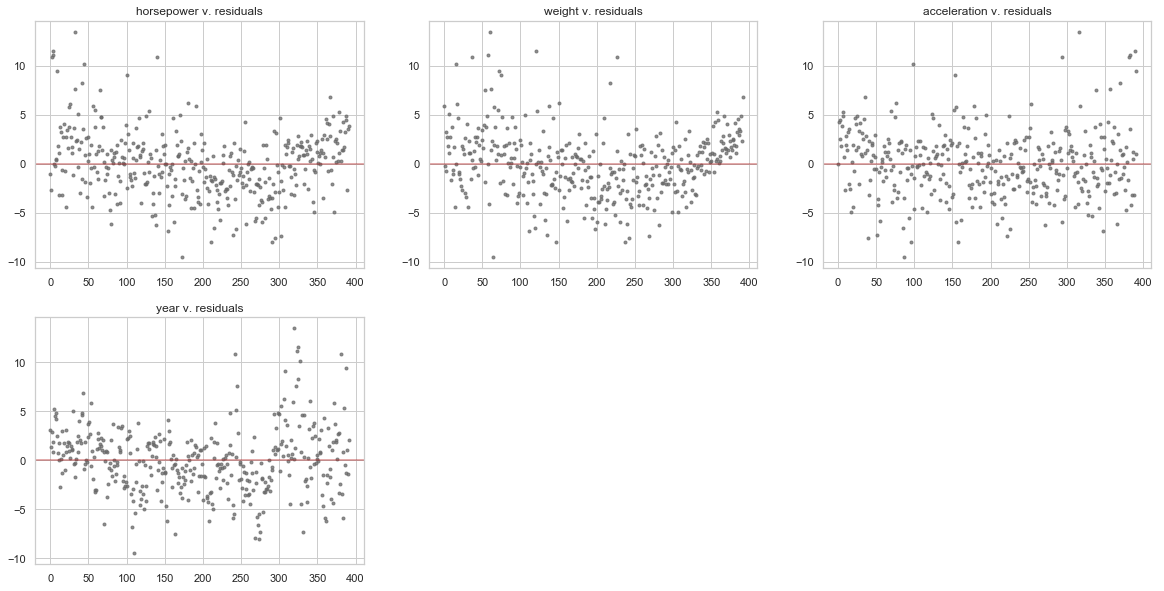

In [25]:
figure = plt.figure(figsize=(20,10))

variables = ["horsepower", "weight", "acceleration", "year"]
plots = len( variables)

rows = (plots // 3) + 1

for i, variable in enumerate( variables):
    axes = figure.add_subplot(rows, 3, i + 1)
    keyed_values = sorted( zip( autompg[ variable].values, result[ "residuals"]),key=lambda x: x[ 0])
    residuals = [x[ 1][ 0] for x in keyed_values]
    axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
    axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="firebrick", alpha=0.5)
    axes.set_title( variable + " v. residuals")

plt.show()
plt.close()

The plots are all pretty much non-linear with a parabolic shape, albiet slightly subtle.

I would like to see how each of these plot against mpg as I didn't do a full EDA on this  data.

In [26]:
def lowess_scatter(data, x, y, jitter=0.0, skip_lowess=False):

    if skip_lowess:
        fit = np.polyfit(data[x], data[y], 1)
        line_x = np.linspace(data[x].min(), data[x].max(), 10)
        line = np.poly1d(fit)
        line_y = list(map(line, line_x))
    else:
        lowess = sm.nonparametric.lowess(data[y], data[x], frac=.3)
        line_x = list(zip(*lowess))[0]
        line_y = list(zip(*lowess))[1]

    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 1, 1)

    xs = data[x]
    if jitter > 0.0:
        xs = data[x] + stats.norm.rvs( 0, 0.5, data[x].size)

    axes.scatter(xs, data[y], marker="o", color="DimGray", alpha=0.5)
    axes.plot(line_x, line_y, color="DarkRed")

    title = "Plot of {0} v. {1}".format(x, y)
    if not skip_lowess:
        title += " with LOWESS"
    axes.set_title(title)
    axes.set_xlabel(x)
    axes.set_ylabel(y)

    plt.show()
    plt.close()

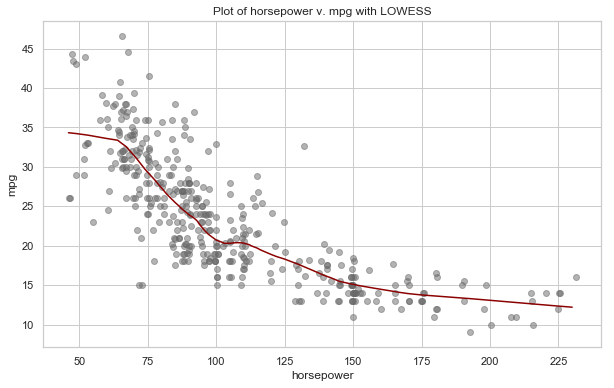

In [27]:
lowess_scatter(autompg, "horsepower", "mpg", jitter=0.01, skip_lowess=False)

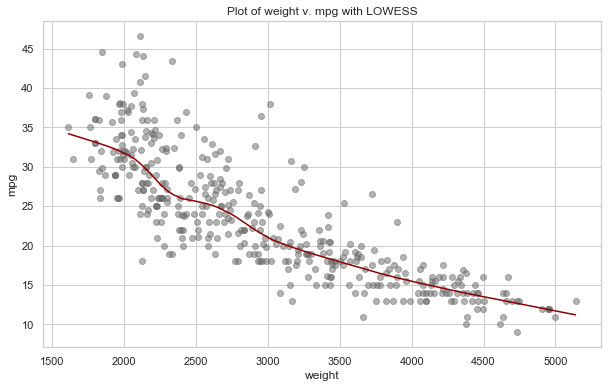

In [28]:
lowess_scatter(autompg, "weight", "mpg", jitter=0.01, skip_lowess=False)

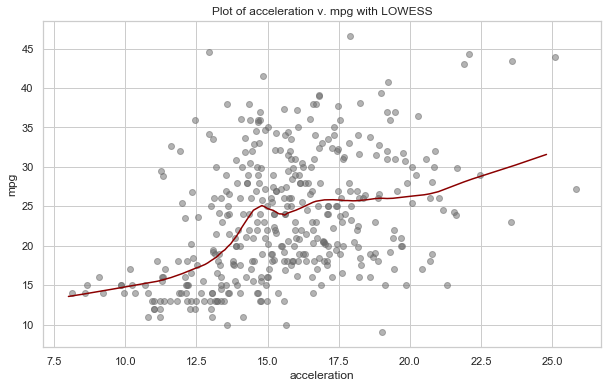

In [29]:
lowess_scatter(autompg, "acceleration", "mpg", jitter=0.01, skip_lowess=False)

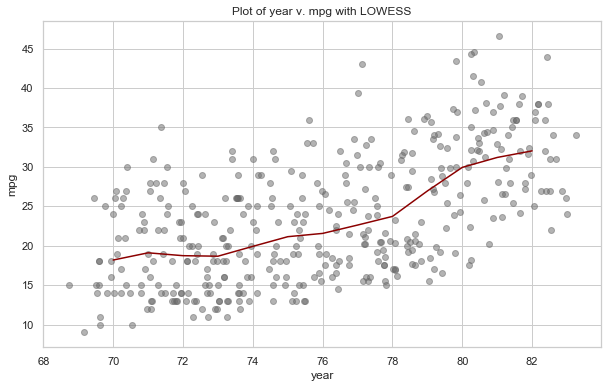

In [30]:
lowess_scatter(autompg, "year", "mpg", jitter=0.01, skip_lowess=False)

From all of these plots, the best candidate for a transformation is horsepower. I will transform horsepower by either taking the log or sqrt. 

In [31]:
#from the book
def log( x):
    return np.log(float( x))

In [32]:
autompg["log_horsepower"] = autompg["horsepower"].apply(log)

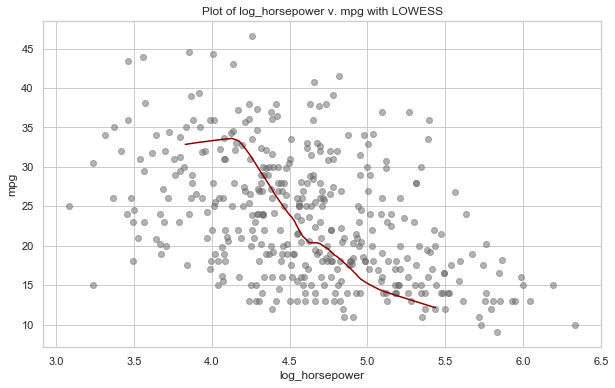

In [33]:
lowess_scatter(autompg, "log_horsepower", "mpg", jitter=0.01, skip_lowess=False)

The log transformation looks much better. I will run the model with that.

In [34]:
model = "mpg ~ log_horsepower + weight + acceleration + year + origin1 + origin2"
result = models.bootstrap_linear_regression(model, data=autompg)
display(models.describe_bootstrap_lr(result))

The R^2 is slightly better. However, weight may be a good log transformation as well.

In [35]:
autompg["log_weight"] = autompg["weight"].apply(log)

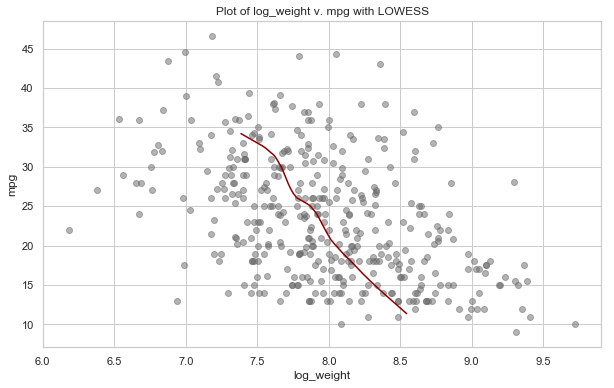

In [36]:
lowess_scatter(autompg, "log_weight", "mpg", jitter=0.01, skip_lowess=False)

Again that looks much better.

In [37]:
model = "mpg ~ log_horsepower + log_weight + acceleration + year + origin1 + origin2"
result = models.bootstrap_linear_regression(model, data=autompg)
display(models.describe_bootstrap_lr(result))

A better R^2 again!

In [38]:
adjusted_r_squared(result)

0.8444688037631183

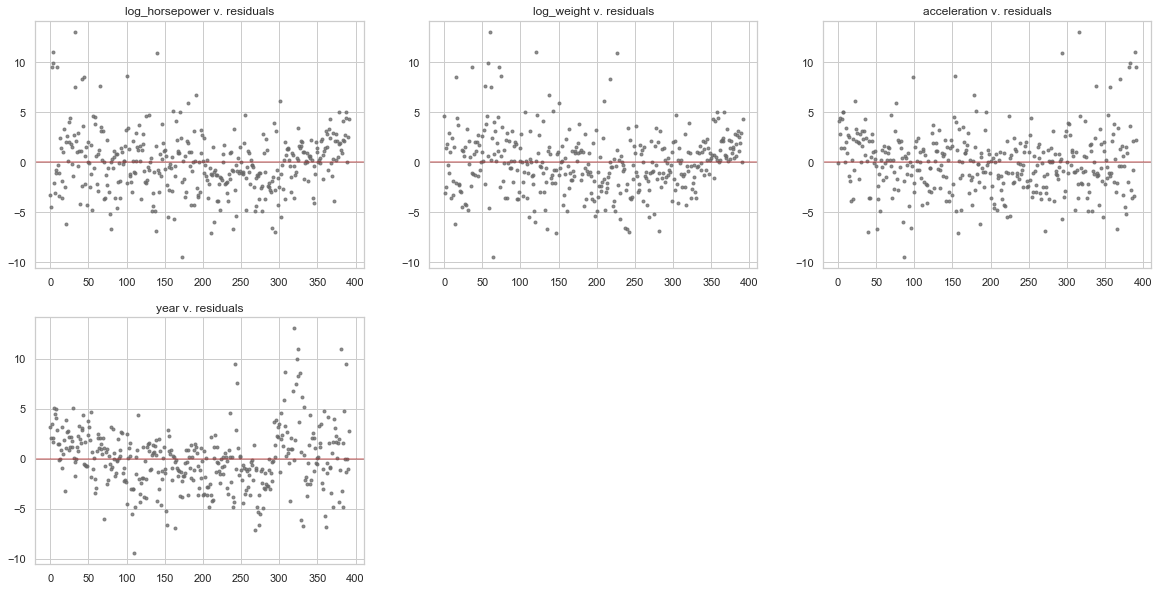

In [39]:
figure = plt.figure(figsize=(20,10))

variables = ["log_horsepower", "log_weight", "acceleration", "year"]
plots = len( variables)

rows = (plots // 3) + 1

for i, variable in enumerate( variables):
    axes = figure.add_subplot(rows, 3, i + 1)
    keyed_values = sorted( zip( autompg[ variable].values, result[ "residuals"]),key=lambda x: x[ 0])
    residuals = [x[ 1][ 0] for x in keyed_values]
    axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
    axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="firebrick", alpha=0.5)
    axes.set_title( variable + " v. residuals")

plt.show()
plt.close()

Each of the residual plots look a bit better however, the logs have some weirdness at the end and the year plot still isn't great. I could also just transform the mpg variable. I can try to square the mpg variable.

In [40]:
autompg["mpg_sq"] = autompg["mpg"]**2

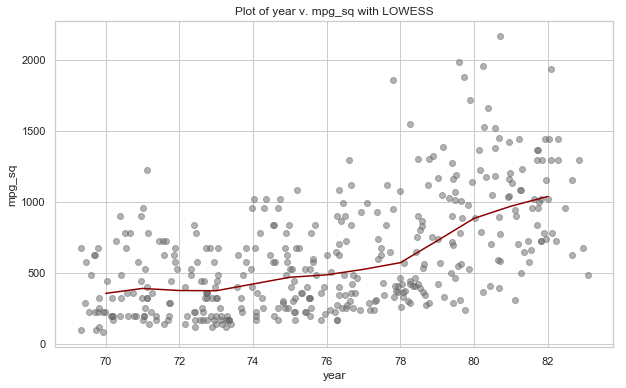

In [41]:
lowess_scatter(autompg, "year", "mpg_sq", jitter=0.01, skip_lowess=False)

That doesn't look better. Should I square year instead?

In [42]:
autompg["year_sq"] = autompg["year"]**2

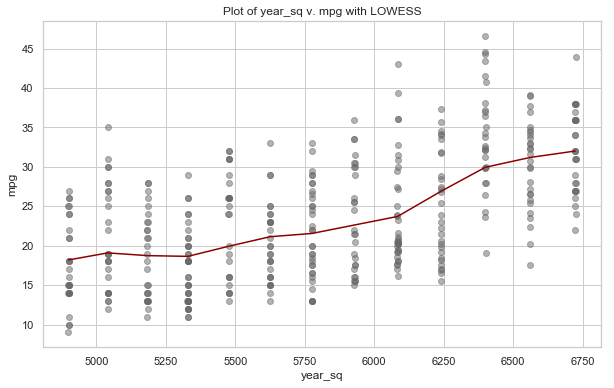

In [43]:
lowess_scatter(autompg, "year_sq", "mpg", jitter=0.01, skip_lowess=False)

Squaring the year really changes up how it displays in the plot but the line looks a bit better. I will try it in the model.

In [44]:
model = "mpg ~ log_horsepower + log_weight + acceleration + year_sq + origin1 + origin2"
result = models.bootstrap_linear_regression(model, data=autompg)
display(models.describe_bootstrap_lr(result))

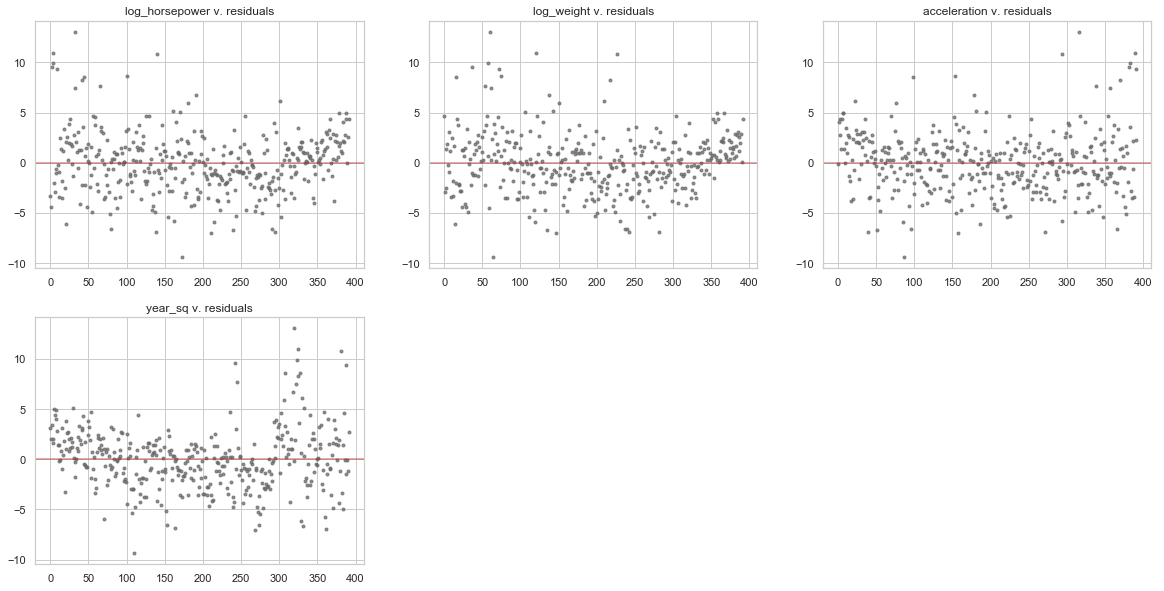

In [45]:
figure = plt.figure(figsize=(20,10))

variables = ["log_horsepower", "log_weight", "acceleration", "year_sq"]
plots = len( variables)

rows = (plots // 3) + 1

for i, variable in enumerate( variables):
    axes = figure.add_subplot(rows, 3, i + 1)
    keyed_values = sorted( zip( autompg[ variable].values, result[ "residuals"]),key=lambda x: x[ 0])
    residuals = [x[ 1][ 0] for x in keyed_values]
    axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
    axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="firebrick", alpha=0.5)
    axes.set_title( variable + " v. residuals")

plt.show()
plt.close()

That still doesn't look as it should. I may just need to transform mpg still. 

In [46]:
autompg["sqrt_mpg"] = autompg["mpg"]**(1/2)

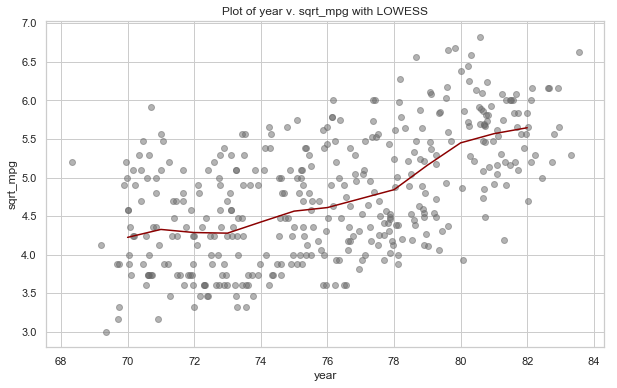

In [47]:
lowess_scatter(autompg, "year", "sqrt_mpg", jitter=0.01, skip_lowess=False)

In [48]:
autompg["log_mpg"] = autompg["mpg"].apply(log)

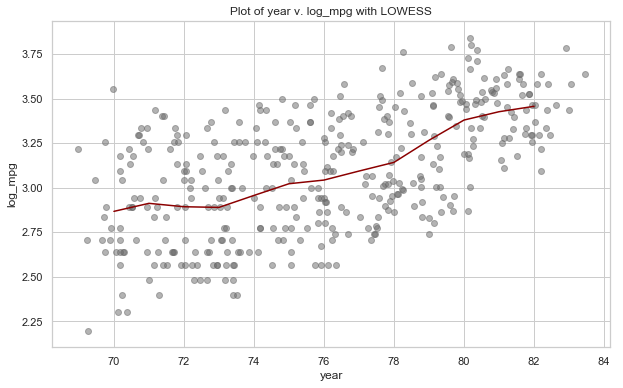

In [49]:
lowess_scatter(autompg, "year", "log_mpg", jitter=0.01, skip_lowess=False)

Log looks a bit better. But that also means I transformed mpg after weight and horsepower. I should review those relationships.

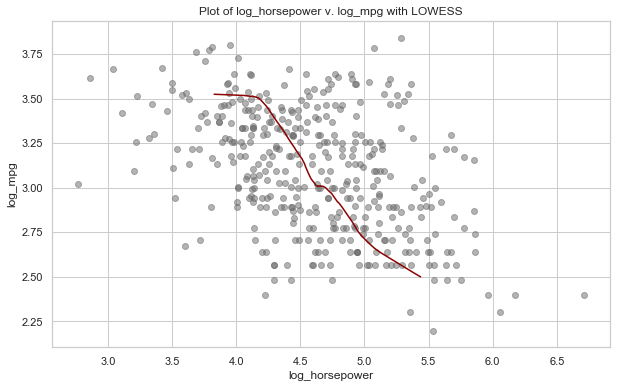

In [50]:
lowess_scatter(autompg, "log_horsepower", "log_mpg", jitter=0.01, skip_lowess=False)

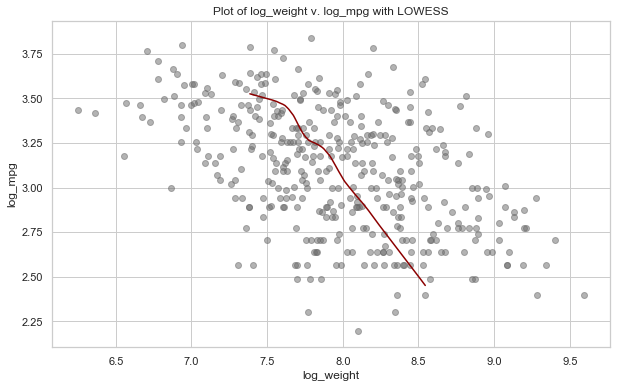

In [51]:
lowess_scatter(autompg, "log_weight", "log_mpg", jitter=0.01, skip_lowess=False)

Those both look fine so I will use the new model with log_mpg added.

In [52]:
model = "log_mpg ~ log_horsepower + log_weight + acceleration + year + origin1 + origin2"
result = models.bootstrap_linear_regression(model, data=autompg)
display(models.describe_bootstrap_lr(result))

That is the best we have gotten so far with the largest R^2 jump as well.

In [53]:
adjusted_r_squared(result)

0.887847333055184

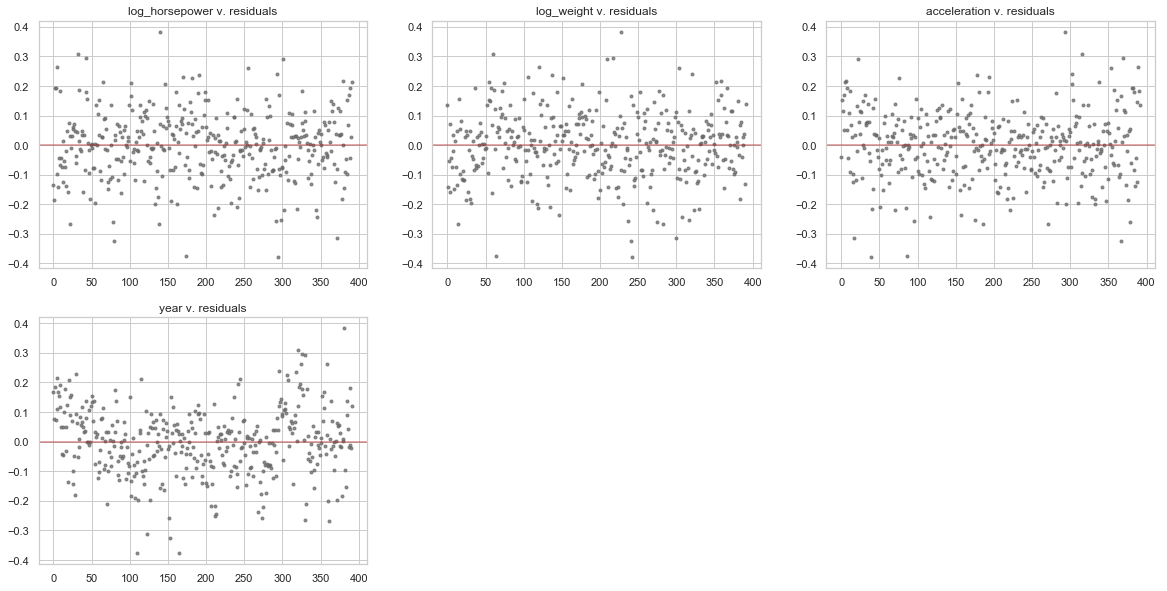

In [54]:
figure = plt.figure(figsize=(20,10))

variables = ["log_horsepower", "log_weight", "acceleration", "year"]
plots = len( variables)

rows = (plots // 3) + 1

for i, variable in enumerate( variables):
    axes = figure.add_subplot(rows, 3, i + 1)
    keyed_values = sorted( zip( autompg[ variable].values, result[ "residuals"]),key=lambda x: x[ 0])
    residuals = [x[ 1][ 0] for x in keyed_values]
    axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
    axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="firebrick", alpha=0.5)
    axes.set_title( variable + " v. residuals")

plt.show()
plt.close()

The residuals do look much better. Year is still a bit non-linear but better than before and the others are much better.

## Model Description and Use

In our final model we have the following variables: log_mpg, log_horsepower, log_weight, acceleration, year, origin1, and origin2. I will walk through them one by one. 

**log_mpg**: This is our target variable. It is the log of the miles per gallon data. That means, given the values and inputs we will get a log value of the mpg. This is the natural log of the value so we will have to take exp(value) to get the mpg.

**log_horsepower**: This variable is the log of horsepower. The coefficient is -0.25. For every increase in 1 log of horsepower, the log of mpg will decrease by 0.25. 

**log_weight**: This variable is the log of weight. The coefficient is -0.66. For every increase in 1 log of weight, the log of mpg will decrease by 0.66. 

**acceleration**: This variable is the acceleration. The coefficient is -0.01, so for every increase in acceleration by 1 unit, the log of mpg will decrease by 0.01.

**year**: The model year has a coefficient of 0.03, so for every year later the car was made the log of mpg will increase by 0.03.

**origin1**: The origin1 variable is a categorical variable that is 1 if true and 0 if the origin is 2 or 3. The coefficient is -0.05 so if the origin of the vehicle is 1 then the log of the mpg will decrease by -0.05.

**origin2**: The origin2 variable is categorical and will be 1 if true and 0 if the origin is 1 or 3. The coefficient is 0.01 so if the origin is 2 then the log of the mpg will increase by 0.01.

**origin3**: The origin3 variable only exists in the model in the absense of origin1 and origin2. If the origin is 3 then origin1 and origin2 will both be 0 so the coefficients will not have an effect.


Lastly the beta 0 coefficient is 7.26. If all of the variables are 0 then the log of mpg will be 7.26. This is not possible since if the vehicle had no weight, acceleration, horsepower, etc, it would also have no mpg. This is a representative extension of the regression.


Now we have this model we can use to predict based on given values. Let's predict the mpg of a vehicle given the following:

Horsepower = 100

Weight = 2845

Acceleration = 16.5

Model Year = 78

Origin = 3

We have translate these into the variables.

In [55]:
horsepower = 100
log_horsepower = np.log(float(horsepower))
weight = 2845
log_weight = np.log(float(weight))
acceleration = 16.5
year = 78
origin1 = 0
origin2 = 0

Let's set the coefficients as well.

In [56]:
b0 = result['coefficients'][0]
b1 = result['coefficients'][1]
b2 = result['coefficients'][2]
b3 = result['coefficients'][3]
b4 = result['coefficients'][4]
b5 = result['coefficients'][5]
b6 = result['coefficients'][6]

In [57]:
log_mpg_hat = b0 + b1*log_horsepower + b2*log_weight + b3*acceleration + b4*year + b5*origin1 + b6*origin2

In [58]:
np.exp(log_mpg_hat)

24.040639545896198

Based on that given vehicle, the mpg is expected to be 24.04 mpg.